In [0]:
# This will be Team 18's Colab notebook for our project on classifying food groups in images
'''
importing necessary libraries
'''
import math
from shutil import copyfile
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt # for plotting
import os
import sys

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# define the training, validation, and testing directories
train_path = '/content/drive/My Drive/Colab Notebooks/APS360/APS360 Project/food-11/training'
valid_path = '/content/drive/My Drive/Colab Notebooks/APS360/APS360 Project/food-11/validation'
test_path = '/content/drive/My Drive/Colab Notebooks/APS360/APS360 Project/food-11/evaluation'

#lucky's path
# train_path = '/content/drive/My Drive/3rd year/2nd semester/aps360/APS360 Project/food-11/training'
# valid_path = '//content/drive/My Drive/3rd year/2nd semester/aps360/APS360 Project/food-11/validation'
# test_path = '/content/drive/My Drive/3rd year/2nd semester/aps360/APS360 Project/food-11/evaluation'

# the food categories in the dataset
classes = ['Bread', 'Dairy product', 'Vegetable/Fruit', 'Dessert', 'Egg', 'Fried food', 'Meat', 'Noodles/Pasta', 'Rice', 'Seafood', 'Soup']

# convert all jpgs to tensors
data_transform = transforms.Compose([transforms.Resize((224,224)), 
                                transforms.ToTensor()])

# load training, validation, and testing data
train_data = torchvision.datasets.ImageFolder(root = train_path, 
                                          transform=data_transform)

val_data = torchvision.datasets.ImageFolder(root = valid_path, 
                                          transform=data_transform)

test_data = torchvision.datasets.ImageFolder(root = test_path, 
                                          transform=data_transform)

print('Number of training images:', len(train_data))
print('Number of validation images:', len(val_data))
print('Number of testing images:', len(test_data))



Number of training images: 9866
Number of validation images: 3430
Number of testing images: 3352


In [0]:
def get_data_loader(batch_size):
    num_workers = 1
    np.random.seed(1000) 
    trainLoader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
    valLoader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
    testLoader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)

    return trainLoader, valLoader, testLoader

In [0]:
train_data.class_to_idx

{'0': 0,
 '1': 1,
 '10': 2,
 '2': 3,
 '3': 4,
 '4': 5,
 '5': 6,
 '6': 7,
 '7': 8,
 '8': 9,
 '9': 10}

Number of training batches: 309
Number of validation batches: 108
Number of testing batches: 105


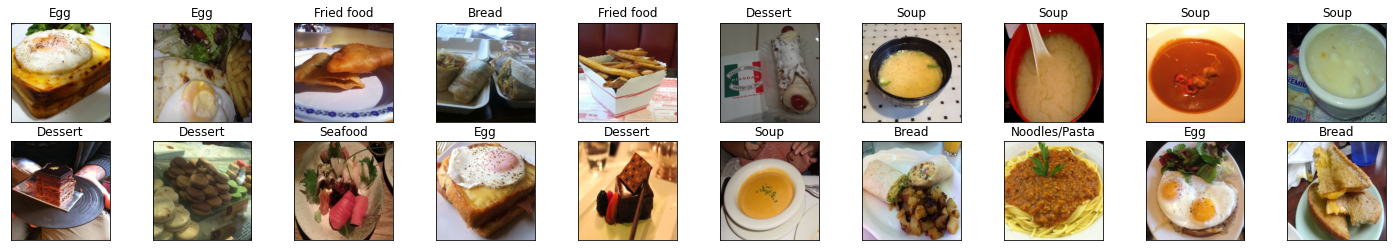

In [0]:
# obtain one batch of training images
train_loader, val_loader, test_loader = get_data_loader(32)

print('Number of training batches:', len(train_loader))
print('Number of validation batches:', len(val_loader))
print('Number of testing batches:', len(test_loader))

dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

In [0]:
# turns classes into a mapping to int
mapping = {
classes[i] : i for i in range(len(classes))
}


'''
BASELINE MODEL-(K-NN)
'''

#probably should consider normalizing the rgb values so we don't risk overflowing

def getAccuracy(pred, labels):
    correct = (pred == labels.numpy().squeeze()).astype(int).sum()
    return correct/float(len(labels))

class baseline:   
    def __init__(self, data_loader):
        #centroids stored as average of RGB
        self.centroids = np.zeros((len(mapping), 3))
        self.calculateCentroids(data_loader)
    
    def calculateCentroids(self, data_loader):
        """
        data_loader with the following aspects:

        data: data set in the shape (# samples, 3 RGB, length, width)
        labels: labels for the data set in the shape (# samples)
        """
        #holds the number of pictures in each class
        count = np.zeros(len(mapping))

        #sum all of the rgb values
        for batch, (data, labels) in enumerate(data_loader):
            #FLATTEN
            data = data.view(data.shape[0], 3, -1)
            #calculate averages for RGB
            avgPixels = np.mean(data.numpy(), axis=2)
            for i, img in enumerate(avgPixels):
                label = labels[i].item()
                self.centroids[label] += avgPixels[i]
                count[label] += 1
            #so we don't spend too much time training
            if batch == 40:
                break

        #average the sum
        for i in range(len(self.centroids)):
            self.centroids[i] /= count[i]

    def forward(self, data):
        """
        data: data set in the shape (# samples, 3 RGB, length, width) 

        returns a list of classes that the model guesses (same as # samples)
        """
        data = data.view(data.shape[0], 3, -1)
        preds = []
        avgImgs = np.mean(data.numpy(), axis=2)
        for avg in avgImgs:
            #initialize to a large number so it gets overwritten
            minDist = sys.maxsize
            guessedLabel = 0
            #get how far the point is from the centroid of each cluster
            #choose the centroid that is closest and classify the point there
            for i, centre in enumerate(self.centroids):
                dist = np.linalg.norm(avg - centre)
                if dist < minDist:
                    minDist = dist
                    guessedLabel = i

            preds.append(guessedLabel)
        
        return preds          


In [0]:
baselineSucksMyAss = baseline(train_loader)

In [0]:
_, val_loader2, _ = get_data_loader(len(val_data.imgs))

for (imgs, labels) in val_loader2:
    preds = baselineSucksMyAss.forward(imgs)
    print(f'preds: {preds}')
    print(f'label: {labels.tolist()}')
    print(f'Accuracy: {getAccuracy(preds, labels)}')
    break

preds: [3, 8, 9, 8, 5, 8, 6, 9, 9, 9, 1, 1, 9, 9, 3, 1, 2, 3, 8, 9, 1, 8, 6, 1, 9, 1, 3, 8, 6, 1, 6, 9, 5, 8, 6, 2, 3, 6, 6, 5, 8, 2, 1, 1, 3, 6, 2, 8, 6, 5, 3, 8, 9, 8, 8, 6, 8, 6, 3, 6, 8, 6, 6, 6, 3, 9, 6, 1, 7, 5, 9, 1, 1, 8, 1, 6, 6, 3, 8, 1, 5, 1, 1, 10, 1, 6, 5, 9, 5, 1, 6, 5, 6, 1, 9, 9, 2, 8, 6, 8, 6, 2, 3, 1, 1, 6, 6, 6, 6, 1, 1, 1, 2, 1, 5, 8, 8, 2, 9, 5, 6, 6, 8, 9, 9, 7, 1, 1, 9, 3, 9, 2, 8, 7, 6, 2, 5, 5, 2, 1, 8, 8, 6, 9, 1, 9, 9, 6, 8, 2, 6, 8, 1, 1, 10, 5, 6, 8, 1, 6, 6, 6, 9, 8, 1, 9, 5, 1, 7, 1, 1, 2, 1, 1, 6, 6, 1, 6, 2, 6, 7, 3, 9, 9, 6, 1, 9, 8, 6, 6, 8, 1, 8, 8, 3, 6, 9, 9, 9, 1, 8, 6, 8, 8, 2, 6, 1, 2, 6, 1, 1, 5, 9, 6, 6, 5, 1, 1, 8, 5, 8, 5, 9, 9, 6, 9, 6, 9, 3, 6, 1, 1, 3, 6, 1, 6, 6, 9, 8, 8, 3, 1, 1, 2, 9, 1, 9, 8, 9, 9, 9, 6, 6, 3, 10, 3, 2, 6, 1, 8, 6, 2, 6, 9, 8, 8, 1, 6, 6, 10, 6, 10, 3, 5, 6, 9, 6, 3, 1, 8, 6, 3, 8, 4, 6, 1, 6, 6, 3, 6, 1, 6, 2, 3, 5, 5, 2, 6, 1, 6, 3, 1, 8, 6, 6, 1, 9, 6, 9, 6, 1, 7, 3, 6, 6, 3, 9, 9, 1, 9, 6, 2, 6, 3, 6, 9, 1, 7, 8, 

In [0]:
class restaurant(nn.Module):
    def __init__(self):
        super(restaurant, self).__init__()
        self.conv1 = nn.Conv2d(3, 5, 5) #in_channels, out_chanels, kernel_size
        self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride
        self.conv2 = nn.Conv2d(5, 10, 5) #in_channels, out_chanels, kernel_size
        self.fc1 = nn.Linear(53*53*10, 32)
        self.fc2 = nn.Linear(32, 11)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 53*53*10)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [0]:
def get_accuracy(model, data, cuda=False):
    correct, total = 0, 0
    for pics, labels in data:
        if use_cuda and torch.cuda.is_available():
          pics = pics.cuda()
          labels = labels.cuda()
        output = model(pics)
        output = output.max(1, keepdim=True)[1]
        correct += output.eq(labels.view_as(output)).sum().item()
        total += labels.shape[0]
    return float(correct / total)

In [0]:
#pass in a data loader
def train_bot(model, train, valid, num_epochs=5, learning_rate=1e-5, plot=True, cuda=False):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_acc, train_loss, val_acc, val_loss = [], [], [], []
    start_time = time.clock()
    print('started the training at {}'.format(start_time))
    for epoch in range(num_epochs):
        print("Epoch {}".format(epoch))
        for pics, labels in train:
            if use_cuda and torch.cuda.is_available():
              pics = pics.cuda()
              labels = labels.cuda()
            pred = model(pics)
            t_loss = criterion(pred.float(), labels)
            t_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        for pics, labels in valid:
            if use_cuda and torch.cuda.is_available():
              pics = pics.cuda()
              labels = labels.cuda()
            pred = model(pics)
            v_loss = criterion(pred, labels)
        val_loss.append(v_loss)
        train_loss.append(t_loss)
        train_acc.append(get_accuracy(model, train))
        val_acc.append(get_accuracy(model, valid))
    end_time = time.clock()
    diff = end_time - start_time
    print('ended the training at {}, time taken is {}'.format(end_time, diff))
    # plotting
    if plot == True:
      plt.title("Training Curve")
      plt.plot(range(num_epochs), train_loss, label="Train loss")
      plt.plot(range(num_epochs), val_loss, label="Valid loss")
      plt.xlabel("Epochs")
      plt.ylabel("Loss")
      plt.legend()
      plt.show()

      plt.title("Training Curve")
      plt.plot(range(num_epochs), train_acc, label="Train")
      plt.plot(range(num_epochs), val_acc, label="Validation")
      plt.xlabel("Iterations")
      plt.ylabel("Training Accuracy")
      plt.legend()
      plt.show()
    print('Most Recent Training Accuracy = ' + str(train_acc[num_epochs-1]))
    print('Most Recent Validation Accuracy = ' + str(val_acc[num_epochs-1]))
    print('Max Training Accuracy = ' + str(max(train_acc)))
    print('Max Validation Accuracy = ' + str(max(val_acc)))
    print('Most Recent Training Loss = ' + str(train_loss[num_epochs-1]))
    print('Most Recent Validation Loss = ' + str(val_loss[num_epochs-1]))
    print('Min Training Loss = ' + str(min(train_loss)))
    print('Min Validation Loss = ' + str(min(val_loss)))

In [0]:
# Data Loading
def get_data_loader_for_smaller_dataset(master_path, batch_size, data_size, num_workers = 1):

  # Transform Settings - Do not use RandomResizedCrop
  transform = transforms.Compose([transforms.Resize((224,224)), 
                                  transforms.ToTensor()])
  train_ratio = 0.6
  val_ratio = 0.2
  test_ratio = 0.2
  num_cat = 11
  file_type = '.jpg'

  train_set_size_per_cat = math.ceil(train_ratio * data_size / num_cat)
  val_set_size_per_cat = math.ceil(val_ratio * data_size / num_cat)
  test_set_size_per_cat = math.ceil(test_ratio * data_size/ num_cat)

  # Goes through students and place them in Train/Validation/Test sets; Therefore no student would show up in 2 sets.
  for set_name in os.listdir(master_path):
    set_path = master_path + '/' + set_name
    for cat in os.listdir(set_path):
      cat_path = set_path + '/' + cat
      if set_name == 'training':
        for i in range(train_set_size_per_cat):
          source_path = cat_path + '/' + cat + '_' + str(i) + file_type
          dest_path = '/content/drive/My Drive/3rd year/2nd semester/aps360/APS360 Project/1000_set/train/' + cat + '/' + cat + '_' + str(i) + file_type
          copyfile(source_path, dest_path)
          print('copied file: ' + source_path + ' to ' + dest_path)
      if set_name == 'validation':
        for i in range(val_set_size_per_cat):
          source_path = cat_path + '/' + cat + '_' + str(i) + file_type
          dest_path = '/content/drive/My Drive/3rd year/2nd semester/aps360/APS360 Project/1000_set/valid/' + cat + '/' + cat + '_' + str(i) + file_type
          copyfile(source_path, dest_path)
          print('copied file: ' + source_path + ' to ' + dest_path)
      if set_name == 'evaluation':
        for i in range(test_set_size_per_cat):
          source_path = cat_path + '/' + cat + '_' + str(i) + file_type
          dest_path = '/content/drive/My Drive/3rd year/2nd semester/aps360/APS360 Project/1000_set/test/' + cat + '/' + cat + '_' + str(i) + file_type
          copyfile(source_path, dest_path)
          print('copied file: ' + source_path + ' to ' + dest_path)
  
  train_path = '/content/drive/My Drive/3rd year/2nd semester/aps360/APS360 Project/1000_set/train/'
  valid_path = '/content/drive/My Drive/3rd year/2nd semester/aps360/APS360 Project/1000_set/valid/'
  test_path = '/content/drive/My Drive/3rd year/2nd semester/aps360/APS360 Project/1000_set/test/'
  trainset = torchvision.datasets.ImageFolder(root = train_path, 
                                            transform=transform)
  valset = torchvision.datasets.ImageFolder(root = valid_path, 
                                            transform=transform)
  testset = torchvision.datasets.ImageFolder(root = test_path, 
                                            transform=transform)
  print('Number of training images:', len(trainset))
  print('Number of validation images:', len(valset))
  print('Number of testing images:', len(testset))
  # Prepare Dataloader
  #Shuffles the data
  train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, 
                                            num_workers=num_workers, shuffle=True)

  val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size, 
                                            num_workers=num_workers, shuffle=True)

  test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, 
                                            num_workers=num_workers, shuffle=True)
  print('Number of training batches:', len(train_loader))
  print('Number of validation batches:', len(val_loader))
  print('Number of testing batches:', len(test_loader))
  
  return train_loader, val_loader, test_loader

['3_0.jpg', '3_1.jpg', '3_2.jpg', '3_15.jpg', '3_3.jpg', '3_16.jpg', '3_4.jpg', '3_17.jpg', '3_5.jpg', '3_18.jpg', '3_6.jpg', '3_7.jpg', '3_8.jpg', '3_9.jpg', '3_10.jpg', '3_11.jpg', '3_12.jpg', '3_13.jpg', '3_14.jpg', '3_19.jpg', '3_20.jpg', '3_21.jpg', '3_22.jpg', '3_23.jpg', '3_24.jpg', '3_25.jpg', '3_26.jpg', '3_27.jpg', '3_28.jpg', '3_29.jpg', '3_30.jpg']
copied file: /content/drive/My Drive/3rd year/2nd semester/aps360/APS360 Project/food-11/validation/3/3_0.jpg to /content/drive/My Drive/3rd year/2nd semester/aps360/APS360 Project/1000_set/valid/3/3_0.jpg
copied file: /content/drive/My Drive/3rd year/2nd semester/aps360/APS360 Project/food-11/validation/3/3_1.jpg to /content/drive/My Drive/3rd year/2nd semester/aps360/APS360 Project/1000_set/valid/3/3_1.jpg
copied file: /content/drive/My Drive/3rd year/2nd semester/aps360/APS360 Project/food-11/validation/3/3_2.jpg to /content/drive/My Drive/3rd year/2nd semester/aps360/APS360 Project/1000_set/valid/3/3_2.jpg
copied file: /conte

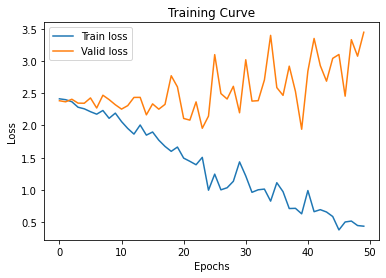

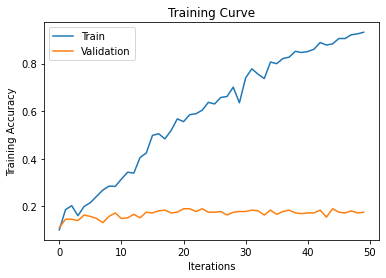

Most Recent Training Accuracy = 0.9315738025415444
Most Recent Validation Accuracy = 0.17595307917888564
Max Training Accuracy = 0.9315738025415444
Max Validation Accuracy = 0.1906158357771261
Most Recent Training Loss = tensor(0.4383, device='cuda:0', grad_fn=<NllLossBackward>)
Most Recent Validation Loss = tensor(3.4455, device='cuda:0', grad_fn=<NllLossBackward>)
Min Training Loss = tensor(0.3807, device='cuda:0', grad_fn=<NllLossBackward>)
Min Validation Loss = tensor(1.9413, device='cuda:0', grad_fn=<NllLossBackward>)


In [0]:
batch = 32
lr = 0.0001
epochs = 50
plot = True
data_size = 1700
use_cuda = True
master_path = '/content/drive/My Drive/3rd year/2nd semester/aps360/APS360 Project/food-11'
print(os.listdir('/content/drive/My Drive/3rd year/2nd semester/aps360/APS360 Project/1000_set/test/3'))
train_loader, val_loader, test_loader = get_data_loader_for_smaller_dataset(master_path, batch, data_size, num_workers = 1)
model = restaurant()
if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
train_bot(model, train_loader, val_loader, epochs, lr, plot, use_cuda)

In [0]:
print(get_accuracy(model, test_loader, use_cuda))

0.22287390029325513


###Try with Alex Net

In [0]:
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

In [0]:
#---------------ALEX NET------------------------
def getSmallerDataLoaders(batch_size=32):
    num_workers = 1
    train_path = '/content/drive/My Drive/Colab Notebooks/APS360/APS360 Project/1000_set/train'
    valid_path = '/content/drive/My Drive/Colab Notebooks/APS360/APS360 Project/1000_set/valid/'
    test_path = '/content/drive/My Drive/Colab Notebooks/APS360/APS360 Project/1000_set/test/'
    trainset = torchvision.datasets.ImageFolder(root = train_path, 
                                            transform=data_transform)
    valset = torchvision.datasets.ImageFolder(root = valid_path, 
                                            transform=data_transform)
    testset = torchvision.datasets.ImageFolder(root = test_path, 
                                            transform=data_transform)
    # Prepare Dataloader
    #Shuffles the data
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, 
                                            num_workers=num_workers, shuffle=True)

    val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size, 
                                            num_workers=num_workers, shuffle=True)

    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, 
                                            num_workers=num_workers, shuffle=True)

    return train_loader, val_loader, test_loader

def getFeatureLoaders(batch_size):
    trainLoader, valLoader, testLoader = getSmallerDataLoaders(batch_size=batch_size)
    trainFeatures, valFeatures, testFeatures = [],[],[]
    trainLabels, valLabels, testLabels = [],[],[]

    for data,labels in trainLoader:
        output = alexnet.features(data)
        trainFeatures.append(output)
        trainLabels.append(labels)

    for data,labels in valLoader:
        output = alexnet.features(data)
        valFeatures.append(output)
        valLabels.append(labels)

    for data,labels in testLoader:
        output = alexnet.features(data)
        testFeatures.append(output)
        testLabels.append(labels)

    return trainFeatures, valFeatures, testFeatures, trainLabels, valLabels, testLabels

In [0]:
#----NEURAL NET FOR ALEX--------------

class foodNetAlex(nn.Module):
    def __init__(self):
        super(foodNetAlex, self).__init__()
        self.name = "alex"
        self.conv1 = nn.Conv2d(256, 256, 3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(256 * 3 * 3, 2048)
        self.fc2 = nn.Linear(2048, 11) 
        #11 output classes
        # self.fc3 = nn.Linear(64, 11) 

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = x.view(-1, 256 * 3* 3)
        x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        x = self.fc2(x)
        return x

In [0]:
def plotGraph(title, xtitle, ytitle, epochs, dataTrain, dataVal, dataTest=None):
    plt.figure(figsize=(10,5))
    plt.title(title)
    plt.xlabel(xtitle)
    plt.ylabel(ytitle)
    plt.plot(range(0, epochs), dataTrain, label="Training")
    plt.plot(range(0, epochs), dataVal, label="Validation")
    if dataTest is not None:
        plt.plot(range(0, epochs), dataTest, label="Testing")
    plt.legend()
    plt.show()

def getAccLossAlex(net, data, labels, lossFunc):
    correct = 0
    loss = 0
    num_data = 0
    for batchNum, inputs in enumerate(data,1):
        batchLabels = labels[batchNum-1]
        if torch.cuda.is_available():
            inputs = inputs.cuda()
            batchLabels = batchLabels.cuda()

        predictions = net(inputs)
        pred = predictions.max(1, keepdim=True)[1]
        correct += pred.eq(batchLabels.view_as(pred)).sum().item()
        lossVal = lossFunc(predictions, batchLabels.long())
        loss += lossVal.item()
        num_data += len(batchLabels)
    return float(correct)/num_data, float(loss)/batchNum 

def train_alexNet(net, trainFeatures, valFeatures, testFeatures, trainLabels, valLabels, testLabels, batch_size=32, learning_rate=0.001, num_epochs=30):

    lossFunc = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)

    train_acc = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)

    #---------------TRAIN----------------
    startTime = time.time()
    for epoch in range(num_epochs):  
        for i, data in enumerate(trainFeatures, 0):
            # Get the inputs
            labels = trainLabels[i]
            
            if torch.cuda.is_available():
                data = data.cuda()
                labels = labels.cuda()            

            # Forward pass, backward pass, optimize and zero gradients
            outputs = net(data)
            loss = lossFunc(outputs, labels.long())
            loss.backward(retain_graph=True)
            optimizer.step()
            optimizer.zero_grad()

        # Calculate the statistics
        train_acc[epoch], train_loss[epoch] = getAccLossAlex(net, trainFeatures, trainLabels, lossFunc)
        val_acc[epoch], val_loss[epoch] = getAccLossAlex(net, valFeatures, valLabels, lossFunc)
        
        # checkpoint the model
        # modelName = getCheckpointName(net, learning_rate, batch_size, epoch)
        # torch.save(net.state_dict(), modelName)

    endTime = time.time()
    print(f'Computation time: {endTime-startTime}')
    print('--------------------------------------------------')
    print(f'FINAL TRAINING ACCURACY: {train_acc[-1]}')
    print(f'FINAL TRAINING LOSS: {train_loss[-1]}')
    print(f'FINAL VALIDATION ACCURACY: {val_acc[-1]}')
    print(f'FINAL VALIDATION LOSS: {val_loss[-1]}\n')

    plotGraph(f"Accuracy in Alex Net - batchSize={batch_size}, lr={learning_rate}", "Epochs", "Accuracy", num_epochs, train_acc, val_acc)
    plotGraph(f"LogSoftmax Loss in Alex Net - batchSize={batch_size}, lr={learning_rate}", "Epochs", "Loss", num_epochs, train_loss, val_loss)

In [0]:
batch_size=32
trainFeatures, valFeatures, testFeatures, trainLabels, valLabels, testLabels = getFeatureLoaders(batch_size)

Model running with CUDA

Computation time: 484.6990239620209
--------------------------------------------------
FINAL TRAINING ACCURACY: 1.0
FINAL TRAINING LOSS: 0.0031276693916879594
FINAL VALIDATION ACCURACY: 0.6158357771260997
FINAL VALIDATION LOSS: 2.5280735059217974



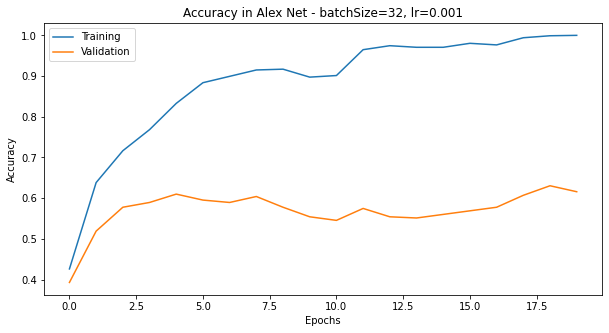

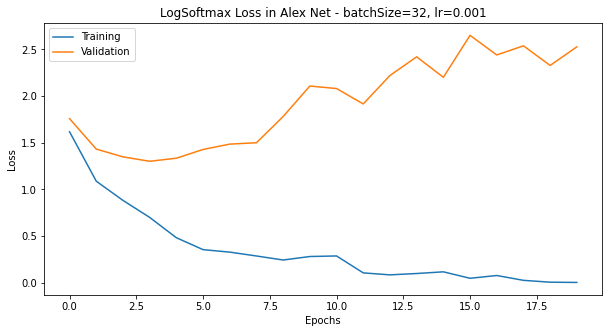

In [0]:
model = foodNetAlex()
if torch.cuda.is_available():
    model = model.cuda()
    print('Model running with CUDA\n')
else:
    print('Model not running with CUDA\n')
train_alexNet(model, trainFeatures, valFeatures, testFeatures, trainLabels, valLabels, testLabels, num_epochs=20)